In [26]:
import os, sys, re, datetime, shutil
import numpy as np
import astropy.units as u
from astropy.table import Table
sys.path.insert(1, os.path.join(os.path.dirname(os.getcwd()), 'utils'))

In [27]:
import moldata
import importlib
importlib.reload(moldata)

<module 'moldata' from '/Users/dzliu/Cloud/GitLab/COExcitation/utils/moldata.py'>

In [28]:
# Define list of parameters

list_N_CO = [5e16, 5e17, 5e18, 5e19]
list_n_H2 = [1e3, 1e4, 1e5, 1e6]
list_T_kin = [25., 50., 100.]

X_CICO = 0.3 # N_CI / N_CO, abundance ratio
X_CICO_suffix = 'sim_XCICO_0p3'

overwrite = False


In [29]:
# Define the function to solve for one (N_X, n_H2, T_kin) parameter set.

def run_for_one_input_set(var_dict):
    # 
    CO = var_dict['CO'] # the moldata class object
    CI = var_dict['CI'] # the moldata class object
    N_CO = var_dict['N_CO'] # species_column_density of CO
    N_CI = var_dict['N_CI'] # species_column_density of CI
    line_width = var_dict['line_width']
    T_kin = var_dict['T_kin']
    collision_partner_densities = var_dict['collision_partner_densities']

    # CI
    CI.evaluate_level_populations(species_column_density = N_CI, 
                                  line_width = line_width, 
                                  T_kin = T_kin, 
                                  collision_partner_densities = collision_partner_densities, 
                                  verbose = False, 
                                  silent = True, 
                                  LTE = True)

    out_table_CI_LTE = CI.get_solved_transition_properties()
    
    CI.solve_rate_matrix_iteratively(verbose = False)
    
    out_table_CI_NonLTE = CI.get_solved_transition_properties()
    
    # CO
    CO.evaluate_level_populations(species_column_density = N_CO, 
                                  line_width = line_width, 
                                  T_kin = T_kin, 
                                  collision_partner_densities = collision_partner_densities, 
                                  verbose = False, 
                                  silent = True, 
                                  LTE = True)
    out_table_CO_LTE = CO.get_solved_transition_properties()
    
    CO.solve_rate_matrix_iteratively(verbose = False)
    
    out_table_CO_NonLTE = CO.get_solved_transition_properties()
    
    # output
    res_dict = {}
    res_dict['out_table_CI_NonLTE'] = out_table_CI_NonLTE
    res_dict['out_table_CI_LTE'] = out_table_CI_LTE
    res_dict['out_table_CO_NonLTE'] = out_table_CO_NonLTE
    res_dict['out_table_CO_LTE'] = out_table_CO_LTE
    res_dict['R_CI10CO21_NonLTE'] = out_table_CI_NonLTE['Flux_Kkms'][0] / out_table_CO_NonLTE['Flux_Kkms'][1]
    res_dict['R_CI10CO21_LTE'] = out_table_CI_LTE['Flux_Kkms'][0] / out_table_CO_LTE['Flux_Kkms'][1]
    res_dict['tau_0_CI10_NonLTE'] = out_table_CI_NonLTE['tau_0'][0]
    res_dict['tau_0_CI10_LTE'] = out_table_CI_LTE['tau_0'][0]
    res_dict['tau_0_CO21_NonLTE'] = out_table_CO_NonLTE['tau_0'][1]
    res_dict['tau_0_CO21_LTE'] = out_table_CO_LTE['tau_0'][1]
    res_dict['T_ex_CI10_NonLTE'] = out_table_CI_NonLTE['T_ex'][0]
    res_dict['T_ex_CI10_LTE'] = out_table_CI_LTE['T_ex'][0]
    res_dict['T_ex_CO21_NonLTE'] = out_table_CO_NonLTE['T_ex'][1]
    res_dict['T_ex_CO21_LTE'] = out_table_CO_LTE['T_ex'][1]
    
    # 
    return res_dict


In [30]:
# Define the function to loop the calculation for a list of (N_X, n_H2, T_kin) parameter sets.

def loop_calc(
        X_CICO = None, 
        out_table_name = None, # 'out_table_R_CI10CO21_sim_XCICO_0p3'
        list_N_CO = None, 
        list_n_H2 = None, 
        list_T_kin = None, 
        overwrite = False, 
    ):
    
    if X_CICO is None: raise InputError('Error! X_CICO is None!')
    if out_table_name is None: raise InputError('Error! out_table_name is None!')
    if list_N_CO is None: raise InputError('Error! list_N_CO is None!')
    if list_n_H2 is None: raise InputError('Error! list_n_H2 is None!')
    if list_T_kin is None: raise InputError('Error! list_T_kin is None!')
    
    if os.path.exists(out_table_name+'.csv'): 
        if not overwrite:
            print('Found file "{}" and overwrite is False. Returning.'.format(out_table_name+'.csv'))
            out_table = Table.read(out_table_name+'.csv', format='csv')
            return out_table
        else:
            print('Found file "{}" and overwrite is True. Backing up it as "{}"'.format(out_table_name+'.csv', out_table_name+'.csv.backup'))
            shutil.move(out_table_name+'.csv', out_table_name+'.csv.backup')
    
    CO = moldata.CO()
    print(CO)
    
    CI = moldata.CI()
    print(CI)
    
    print('datetime.datetime.now()', datetime.datetime.now())
    
    var_dict = {'CO': CO, 'CI': CI}
    out_dict = {}
    out_dict['N_CO'] = []
    out_dict['N_CI'] = []
    out_dict['line_width'] = []
    out_dict['T_kin'] = []
    out_dict['n_H2'] = []
    out_dict['tau_0_CI10_NonLTE'] = []
    out_dict['tau_0_CI10_LTE'] = []
    out_dict['tau_0_CO21_NonLTE'] = []
    out_dict['tau_0_CO21_LTE'] = []
    out_dict['T_ex_CI10_NonLTE'] = []
    out_dict['T_ex_CI10_LTE'] = []
    out_dict['T_ex_CO21_NonLTE'] = []
    out_dict['T_ex_CO21_LTE'] = []
    out_dict['R_CI10CO21_NonLTE'] = []
    out_dict['R_CI10CO21_LTE'] = []
    for N_CO in list_N_CO:
        for n_H2 in list_n_H2:
            for T_kin in list_T_kin:
                var_dict['N_CO'] = N_CO * u.cm**(-2)
                var_dict['N_CI'] = X_CICO * N_CO * u.cm**(-2) #<TODO># CI CO abundance ratio? -- <20210902> trying 0.2 instead of 0.1
                var_dict['line_width'] = 20. * u.km/u.s #<TODO># line width
                var_dict['T_kin'] = T_kin * u.K
                var_dict['n_H2'] = n_H2 * u.cm**(-3)
                var_dict['collision_partner_densities'] = {'ortho-H2': 0.75 * n_H2 * u.cm**(-3), 'para-H2': 0.25 * n_H2 * u.cm**(-3)}

                tmp_dict = run_for_one_input_set(var_dict)

                out_dict['N_CO'].append(var_dict['N_CO'])
                out_dict['N_CI'].append(var_dict['N_CI'])
                out_dict['line_width'].append(var_dict['line_width'])
                out_dict['T_kin'].append(var_dict['T_kin'])
                out_dict['n_H2'].append(var_dict['n_H2'])
                out_dict['tau_0_CI10_NonLTE'].append(tmp_dict['tau_0_CI10_NonLTE'])
                out_dict['tau_0_CI10_LTE'].append(tmp_dict['tau_0_CI10_LTE'])
                out_dict['tau_0_CO21_NonLTE'].append(tmp_dict['tau_0_CO21_NonLTE'])
                out_dict['tau_0_CO21_LTE'].append(tmp_dict['tau_0_CO21_LTE'])
                out_dict['T_ex_CI10_NonLTE'].append(tmp_dict['T_ex_CI10_NonLTE'])
                out_dict['T_ex_CI10_LTE'].append(tmp_dict['T_ex_CI10_LTE'])
                out_dict['T_ex_CO21_NonLTE'].append(tmp_dict['T_ex_CO21_NonLTE'])
                out_dict['T_ex_CO21_LTE'].append(tmp_dict['T_ex_CO21_LTE'])
                out_dict['R_CI10CO21_NonLTE'].append(tmp_dict['R_CI10CO21_NonLTE'])
                out_dict['R_CI10CO21_LTE'].append(tmp_dict['R_CI10CO21_LTE'])

    print('datetime.datetime.now()', datetime.datetime.now())

    out_table = Table(out_dict)
    out_table.write(out_table_name+'.csv', format='csv', overwrite=overwrite)
    out_table.write(out_table_name+'.dat', format='ascii.fixed_width', delimiter='  ', bookend=True, overwrite=overwrite)
    
    return out_table


In [49]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import gridspec
from matplotlib import cm
from matplotlib import ticker

# Define the function to plot a figure

def plot_calc(
        in_table = None, 
        out_figure_name = None, 
        out_figure_type = 'pdf', 
        out_figure_dpi = 300, 
        plot_variable = 'LTE_NonLTE_bias', 
        colorbar_ticks = None, 
        list_N_CO = None, 
        list_n_H2 = None, 
        list_T_kin = None, 
        minima = None, 
        maxima = None, 
    ):
    
    if in_table is None: raise InputError('Error! in_table is None!')
    if out_figure_name is None: raise InputError('Error! out_figure_name is None!')
    if list_N_CO is None: raise InputError('Error! list_N_CO is None!')
    if list_n_H2 is None: raise InputError('Error! list_n_H2 is None!')
    if list_T_kin is None: raise InputError('Error! list_T_kin is None!')
    
    if plot_variable == '' or plot_variable == 'LTE_NonLTE_bias':
        colorbar_title = r'$R_{\mathrm{CI10}/\mathrm{CO21}}$'+'\n'+r'$\mathrm{nonLTE}/\mathrm{LTE}$'
        variable_array = in_table['R_CI10CO21_NonLTE']/in_table['R_CI10CO21_LTE']
    elif plot_variable == 'LTE':
        colorbar_title = r'$R_{\mathrm{CI10}/\mathrm{CO21}}$'+'\n'+r'$\mathrm{LTE}$'
        variable_array = in_table['R_CI10CO21_LTE']
    elif plot_variable == 'NonLTE':
        colorbar_title = r'$R_{\mathrm{CI10}/\mathrm{CO21}}$'+'\n'+r'$\mathrm{NonLTE}$'
        variable_array = in_table['R_CI10CO21_NonLTE']
    else:
        raise ValueError('Error! plot_variable should be either "LTE_NonLTE_bias" or "LTE" or "NonLTE"!')
    
    if minima is None:
        minima = np.min(variable_array)
    if maxima is None:
        maxima = np.max(variable_array)
    print('minima', minima, 'maxima', maxima)
    # norm = matplotlib.colors.Normalize(vmin=minima, vmax=maxima, clip=True)
    norm = matplotlib.colors.LogNorm(vmin=minima, vmax=maxima, clip=True)
    cmap = cm.RdBu_r # cm.jet # cm.viridis # cm.RdYlBu_r
    colormapper = cm.ScalarMappable(norm=norm, cmap=cmap)
    
    vmidlow = 10**((np.log10(maxima) + np.log10(minima)) / 2.0 - (np.log10(maxima) - np.log10(minima)) * 0.33 / 2.0)
    vmidhigh = 10**((np.log10(maxima) + np.log10(minima)) / 2.0 + (np.log10(maxima) - np.log10(minima)) * 0.33 / 2.0)
    print('vmidlow', vmidlow, 'vmidhigh', vmidhigh)

    fig = plt.figure(figsize=(12, 4))
    fig.subplots_adjust(left=0.04, right=0.96, bottom=0.18, top=0.82)
    gs = gridspec.GridSpec(ncols=len(list_T_kin)+1, nrows=1, figure=fig, width_ratios=[1]*len(list_T_kin)+[0.08], wspace=0, hspace=0)
    axes = []
    for i in range(len(list_T_kin)):
        axes.append(fig.add_subplot(gs[0, i]))
    for iax, T_kin in enumerate(list_T_kin):
        axes[iax].set_xlabel('n_H2', fontsize='x-large', labelpad=6)
        if iax == 0: axes[iax].set_ylabel('N_CO', fontsize='x-large', labelpad=12)
        axes[iax].set_xlim([0, len(list_n_H2)]) # number of n_H2
        axes[iax].set_ylim([0, len(list_N_CO)]) # number of N_CO
        axes[iax].set_xticks(np.arange(len(list_n_H2))+0.5)
        axes[iax].set_yticks(np.arange(len(list_N_CO))+0.5)
        axes[iax].set_xticklabels(['%.0e'%(t) for t in list_n_H2])
        axes[iax].set_yticklabels(['%.0e'%(t) for t in list_N_CO])
        axes[iax].tick_params(labelsize='large')
        axes[iax].set_aspect(1.0)
        axes[iax].set_title('T_kin = {}'.format(T_kin), fontsize='x-large', pad=12)

    ax_colorbar = fig.add_subplot(gs[0, -1])
    ax_colorbar.set_title(colorbar_title, fontsize='x-large', pad=10)
    ax_colorbar.tick_params(labelsize='large')
    cbar = fig.colorbar(mappable=colormapper, cax=ax_colorbar)
    #cbar.set_ticks(np.arange(len(list_T_kin))+0.5)
    if colorbar_ticks is not None:
        cbar.set_ticks(colorbar_ticks)
    #cbar.ax.yaxis.set_major_locator(ticker.MultipleLocator())
    cbar.ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%g"))
    cbar.ax.yaxis.set_minor_formatter(ticker.NullFormatter())
    cbar.ax.yaxis.set_minor_locator(ticker.LogLocator())
    
    # the input table must have rows in the order of [N_CO, n_H2, T_kin], where T_kin changes the fastest, then n_H2, then N_CO. 
    for iy, N_CO in enumerate(list_N_CO):
        for ix, n_H2 in enumerate(list_n_H2):
            for iax, T_kin in enumerate(list_T_kin):
                ax = axes[iax]
                irow = iy*len(list_n_H2)*len(list_T_kin) + ix*len(list_T_kin) + iax
                x = n_H2
                y = N_CO
                v = variable_array[irow]
                ax.fill_between([ix, ix+1], [iy, iy], [iy+1, iy+1], color=colormapper.to_rgba(v), alpha=1.0, lw=0.0)
                if v < vmidlow or v > vmidhigh:
                    text_color = 'w'
                else:
                    text_color = 'k'
                ax.text(ix+0.5, iy+0.5, '{:.2f}'.format(v), ha='center', va='center', color=text_color, fontsize='large')

    # for iax, T_kin in enumerate([25., 50., 100.]):
    #     ax = axes[iax]
    #     ax.set_xscale('log')
    #     ax.set_yscale('log')
    #     ax.set_xlim([1e3, 1e5])
    #     ax.set_ylim([5e16, 5e18])
    #     mask = np.isclose(in_table['T_kin'], T_kin, rtol=0.1, atol=0.0)
    #     R_CI10CO21_NonLTE = in_table['R_CI10CO21_NonLTE'][mask]
    #     R_CI10CO21_LTE = in_table['R_CI10CO21_LTE'][mask]
    #     x = in_table['n_H2'][mask]
    #     y = in_table['N_CO'][mask]
    #     v = R_CI10CO21_NonLTE/R_CI10CO21_LTE
    #     x = [1e3, 1e4, 1e5]
    #     y = [5e16, 5e17, 5e18]
    #     v = v.reshape((3,3))
    #     ax.pcolormesh(x, y, v, norm=norm, cmap=cmap)
    #     # ax.pcolor(v, norm=norm, cmap=cmap)
    
    out_figure_file = out_figure_name + '.' + out_figure_type # 'Plot_RCI10CO21_nonLTE_LTE_ratio_sim_XCICO_0p3.pdf'
    fig.savefig(out_figure_file, dpi = out_figure_dpi)
    print(f'Output to "{out_figure_file}"')
    
    return fig


In [32]:
# Main Calculation

out_table = loop_calc(
        X_CICO = X_CICO, 
        out_table_name = 'out_table_R_CI10CO21_' + X_CICO_suffix, 
        list_N_CO = list_N_CO, 
        list_n_H2 = list_n_H2, 
        list_T_kin = list_T_kin, 
        overwrite = overwrite, 
)

out_table

Found file "out_table_R_CI10CO21_sim_XCICO_0p3.csv" and overwrite is False. Returning.


N_CO,N_CI,line_width,T_kin,n_H2,tau_0_CI10_NonLTE,tau_0_CI10_LTE,tau_0_CO21_NonLTE,tau_0_CO21_LTE,T_ex_CI10_NonLTE,T_ex_CI10_LTE,T_ex_CO21_NonLTE,T_ex_CO21_LTE,R_CI10CO21_NonLTE,R_CI10CO21_LTE
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
5e+16,1.5e+16,20.0,25.0,1000.0,0.006160428256506423,0.0035523011261493105,0.8351749050981341,0.21706704192725337,16.513511105858385,25.0,8.737338521043398,25.0,0.019415385059288102,0.013869132346596768
5e+16,1.5e+16,20.0,50.0,1000.0,0.00291370680192335,0.001310207387821091,0.6822014875475466,0.06855076444514997,29.191016636574982,50.0,11.066087655062933,50.0,0.017855202487412104,0.017379183500348623
5e+16,1.5e+16,20.0,100.0,1000.0,0.0013779185527913326,0.0005211724969333411,0.5523133519900959,0.01928887471882151,51.807456433786314,100.0,13.548570169482892,100.0,0.015488180730620856,0.025619455935109062
5e+16,1.5e+16,20.0,25.0,10000.0,0.0038322729614806727,0.0035523011261493105,0.3533905366791362,0.21706704192725337,23.764707574356915,25.0,19.315061357807846,25.0,0.01263246133957732,0.013869132346596768
5e+16,1.5e+16,20.0,50.0,10000.0,0.0014128416890282003,0.001310207387821091,0.16434062095928076,0.06855076444514997,48.30047028413319,50.0,34.845414827930774,50.0,0.011861483402902826,0.017379183500348623
5e+16,1.5e+16,20.0,100.0,10000.0,0.0005338717531186036,0.0005211724969333411,0.059214400556967556,0.01928887471882151,102.1767524191021,100.0,77.60382930108119,100.0,0.01170788983505652,0.025619455935109062
5e+16,1.5e+16,20.0,25.0,100000.0,0.0035798284311567177,0.0035523011261493105,0.2330914885913415,0.21706704192725337,24.875476179600934,25.0,24.483994739631445,25.0,0.013359889711488746,0.013869132346596768
5e+16,1.5e+16,20.0,50.0,100000.0,0.0013189923514865458,0.001310207387821091,0.07826950042048958,0.06855076444514997,49.88228417754629,50.0,50.08977745312825,50.0,0.015320640108550372,0.017379183500348623
5e+16,1.5e+16,20.0,100.0,100000.0,0.0005210124593264411,0.0005211724969333411,0.022783227302494748,0.01928887471882151,100.51039333520836,100.0,111.05003329382228,100.0,0.019557835054900632,0.025619455935109062


minima 0.5 maxima 2.0
vmidlow 0.7955364837549187 vmidhigh 1.2570133745218284
Output to "Plot_RCI10CO21_nonLTE_LTE_ratio_sim_XCICO_0p3"


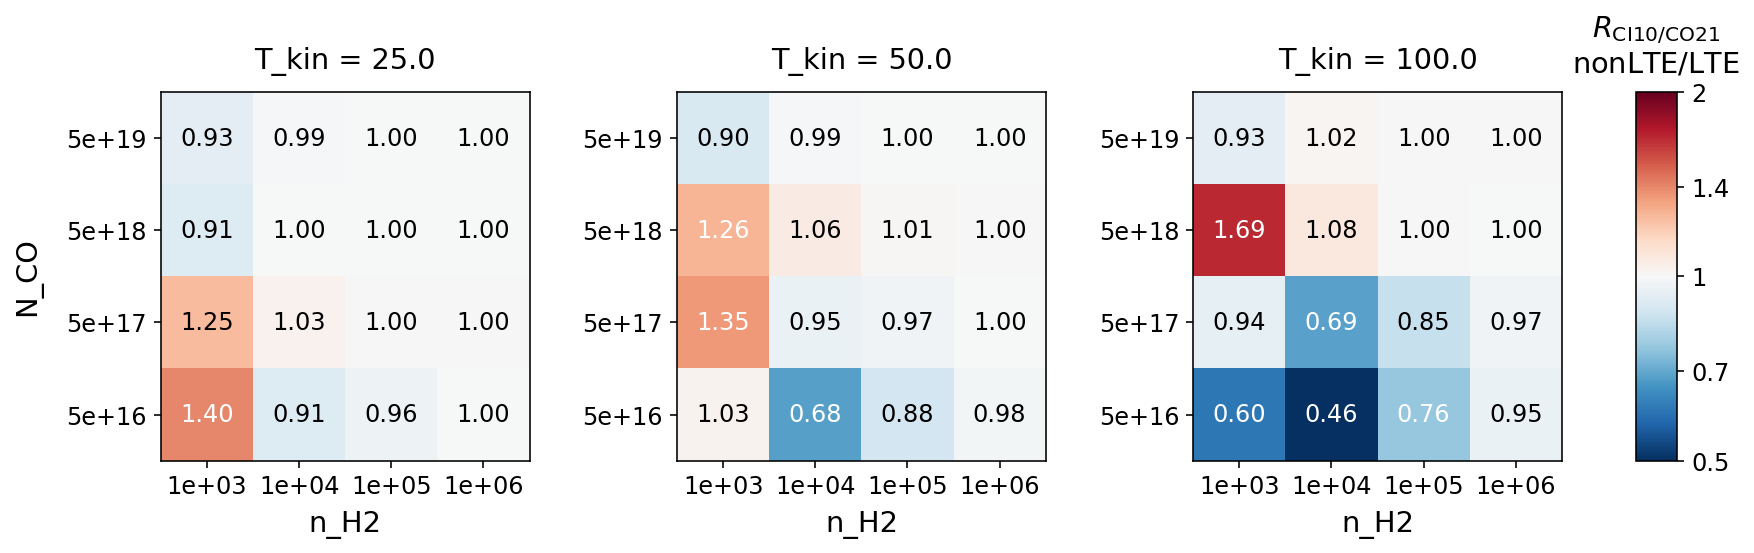

In [46]:
# Main 2

fig = plot_calc(
        out_table, 
        out_figure_name = 'Plot_RCI10CO21_nonLTE_LTE_ratio_' + X_CICO_suffix, 
        list_N_CO = list_N_CO, 
        list_n_H2 = list_n_H2, 
        list_T_kin = list_T_kin, 
        minima = 0.5, 
        maxima = 2.0, 
        colorbar_ticks = [0.5, 0.7, 1.0, 1.4, 2.0], 
)

#fig

minima 0.07 maxima 0.75
vmidlow 0.15493007098000167 vmidhigh 0.3388625569452989
Output to "Plot_RCI10CO21_pred_with_LTE_sim_XCICO_0p3.pdf"


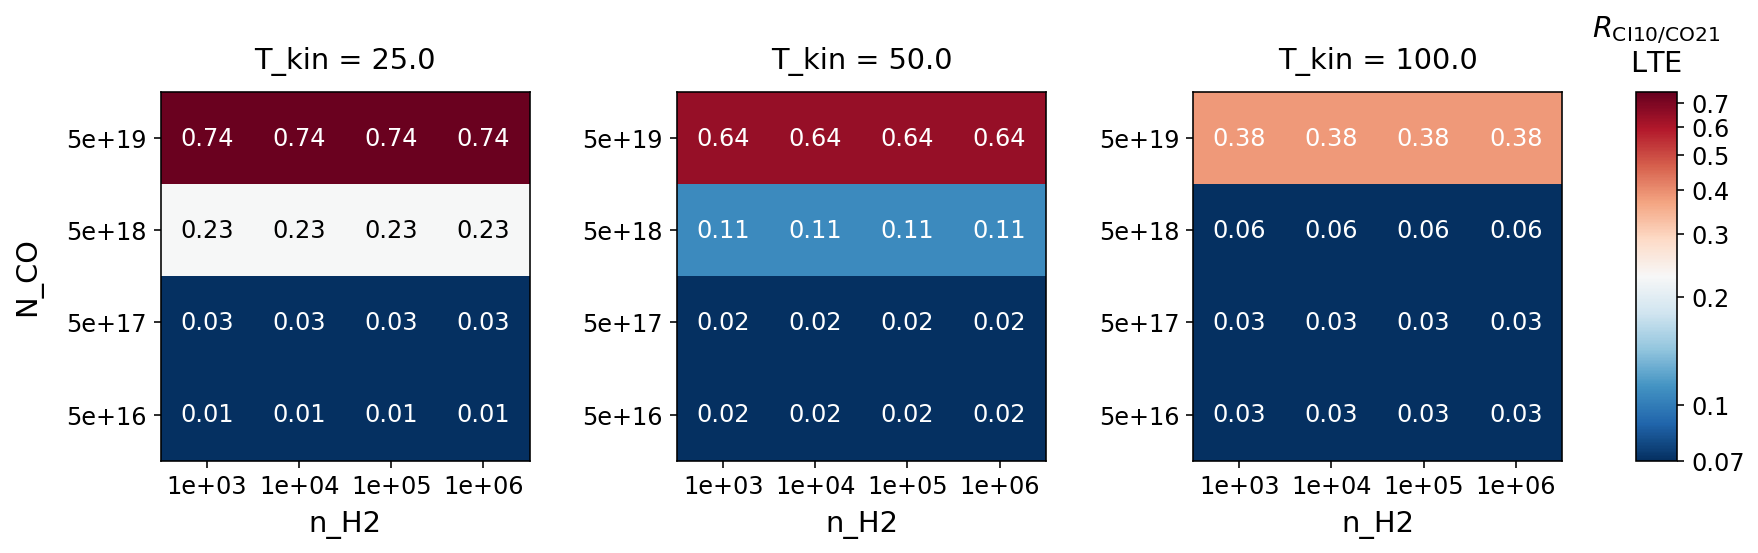

In [51]:
# Main 3

fig = plot_calc(
        out_table, 
        out_figure_name = 'Plot_RCI10CO21_pred_with_LTE_' + X_CICO_suffix, 
        plot_variable = 'LTE', 
        list_N_CO = list_N_CO, 
        list_n_H2 = list_n_H2, 
        list_T_kin = list_T_kin, 
        minima = 0.07, 
        maxima = 0.75, 
        colorbar_ticks = [0.07, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7], 
)

#fig

minima 0.07 maxima 0.75
vmidlow 0.15493007098000167 vmidhigh 0.3388625569452989
Output to "Plot_RCI10CO21_pred_with_NonLTE_sim_XCICO_0p3.pdf"


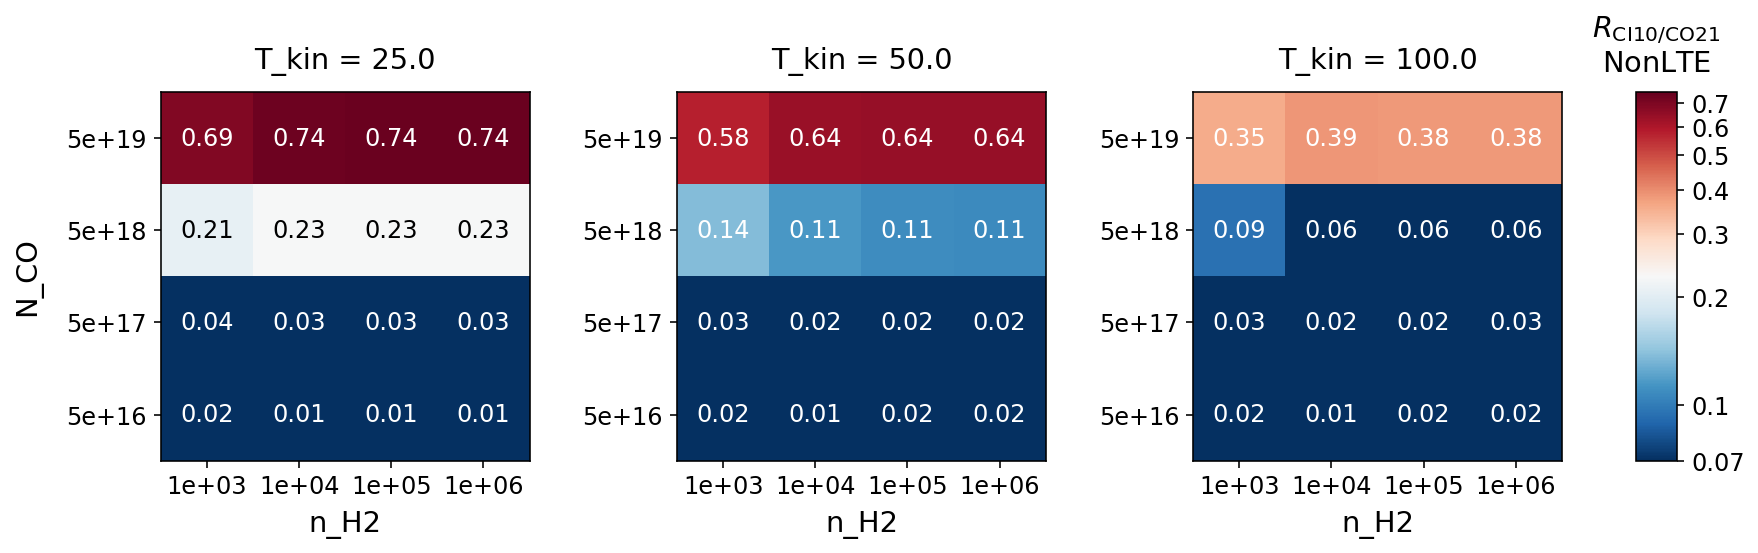

In [50]:
# Main 4

fig = plot_calc(
        out_table, 
        out_figure_name = 'Plot_RCI10CO21_pred_with_NonLTE_' + X_CICO_suffix, 
        plot_variable = 'NonLTE', 
        list_N_CO = list_N_CO, 
        list_n_H2 = list_n_H2, 
        list_T_kin = list_T_kin, 
        minima = 0.07, 
        maxima = 0.75, 
        colorbar_ticks = [0.07, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7], 
)

#fig